In [1]:
%matplotlib inline
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from pathlib import Path
import requests
DATA_PATH = Path('data')
PATH = DATA_PATH / "mnist"
PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (Path / FILENAME).open('wb').write(content)

In [3]:
import pickle
import gzip

with gzip.open((PATH/FILENAME).as_posix(),'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)


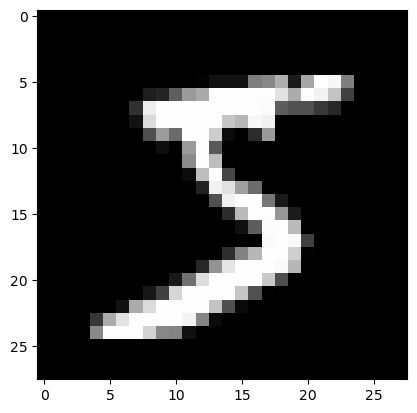

In [4]:
from matplotlib import pyplot
import numpy as np
pyplot.imshow(x_train[0].reshape((28,28)), cmap="gray")
print(x_train.shape)

In [5]:
import torch
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, x_train.shape, y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) torch.Size([50000, 784]) tensor(0) tensor(9)


In [6]:
import torch.nn.functional as F
loss_func = F.cross_entropy

def model(xb):
    return xb.mm(weights) + bias

In [7]:
bs = 64
xb = x_train[0:bs]
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype=torch.float, requires_grad=True)
bias = torch.zeros(10, requires_grad=True)
print(loss_func(model(xb), yb))

tensor(17.7323, grad_fn=<NllLossBackward0>)


In [8]:
from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out = nn.Linear(256, 10)
    
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [9]:
net = Mnist_NN()
print(net)

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


In [10]:
# 快速数据
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

In [11]:
def get_data(train_ds, valid_ds, bs):
    return {
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs*2)
    }

In [12]:
import numpy as np

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb),yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums))/np.sum(nums)
        print('当前step:',str(step)," 验证机损失：", str(val_loss))
    

In [13]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [15]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(25, model, loss_func, opt, train_dl, valid_dl)

当前step: 0  验证机损失： 2.269822863006592
当前step: 1  验证机损失： 2.2263081451416014
当前step: 2  验证机损失： 2.156790064239502
当前step: 3  验证机损失： 2.0412079528808595
当前step: 4  验证机损失： 1.8577224468231202
当前step: 5  验证机损失： 1.611424765586853
当前step: 6  验证机损失： 1.3551298904418945
当前step: 7  验证机损失： 1.137885019683838
当前step: 8  验证机损失： 0.9708729722976684
当前step: 9  验证机损失： 0.8462860934257508
当前step: 10  验证机损失： 0.7530700193405151
当前step: 11  验证机损失： 0.6812202902793885
当前step: 12  验证机损失： 0.6255750373840332
当前step: 13  验证机损失： 0.5802480286598205
当前step: 14  验证机损失： 0.5433904839038849
当前step: 15  验证机损失： 0.513162243270874
当前step: 16  验证机损失： 0.4880938542366028
当前step: 17  验证机损失： 0.46655272941589354
当前step: 18  验证机损失： 0.448056258058548
当前step: 19  验证机损失： 0.43219648561477664
当前step: 20  验证机损失： 0.4189194299697876
当前step: 21  验证机损失： 0.40679081077575685
当前step: 22  验证机损失： 0.3965424690961838
当前step: 23  验证机损失： 0.3866633982658386
当前step: 24  验证机损失： 0.3788423140287399
